In [1]:
#### Entire notebook written by Eric Emdee, email eemdee@pppl.gov if you have questions ####

In [2]:
functionDocLoc = '/home/eric/Documents/Thesis/analysisCode/EAST/'
#this is the location of functionDoc.py
import sys
sys.path.insert(0,functionDocLoc)

In [3]:
# reloads functionDoc in case you made any changes
from importlib import reload
import functionDoc
reload(functionDoc)
from functionDoc import *

In [4]:
# below is directory of the SOLPS output (b2fstate, b2fgmtry, b2fplasmf, fort.*... etc)
rundir = '/home/eric/Documents/Thesis/analysisCode/runs/NSTX/204202.00461_newRelease/autoTC_7_cont/'
# directory to save plots is below, I don't have it saving anything right now so I don't need it
# if you want it to save something look at plotvar in functionDoc.py 
# and you can see the input for turning on saving
# plotdir = '/home/eric/Documents/Thesis/analysisCode/NSTX/204202.00561/release307Branch_Dpuff/heatDiffScan8_Pin=2.25_radialTC_mpi_fromScratch/'
colors = ['r','b','k','m','c','g','y']# some colors, useful for plotting

#location of the SOLPS data for each file

#these two are B2 files
b2fstateLoc = rundir+'b2fstate'
b2fgmtryLoc = rundir+'b2fgmtry'
b2fplasmfLoc = rundir+'b2fplasmf'

#These five are EIRENE files
ft33Loc = rundir+'fort.33'
ft34Loc = rundir+'fort.34'
ft35Loc = rundir+'fort.35'
ft44Loc = rundir+'fort.44'# these are the EIRENE quantities projected onto the B2 grid
ft46Loc = rundir+'fort.46'

# reading the data with these functions
# returns classes which we can call parameters from
b2fstate = read_b2fstate(b2fstateLoc)
b2fgmtry = read_b2fgmtry(b2fgmtryLoc)
dims = np.shape(b2fstate.na)
b2fplasmf = read_b2fplasmf(b2fplasmfLoc,dims[0]-2,dims[1]-2,dims[2])# The extra dimension input is to account for the guard cells
ft44 = read_ft44(ft44Loc)
b2wdat = read_b2wdat(rundir,2)
# assumes b2wdat_iout=4 output is in a directory called output/ within rundir
# currently looking at a case with 2 species


read_b2fstate -- file version 03.000.006
done reading state file
read_b2fgmtry -- file version 03.000.006
done reading geometry file
read_b2fplasmf -- file version 03.000.006
done reading b2fplasmf
read_ft44: assuming nlwrmsh = 1, nfla = 1.
read_ft44: unknown format of fort.44 file (this is usually fine)
done reading ft44 file
done reading b2wdat files


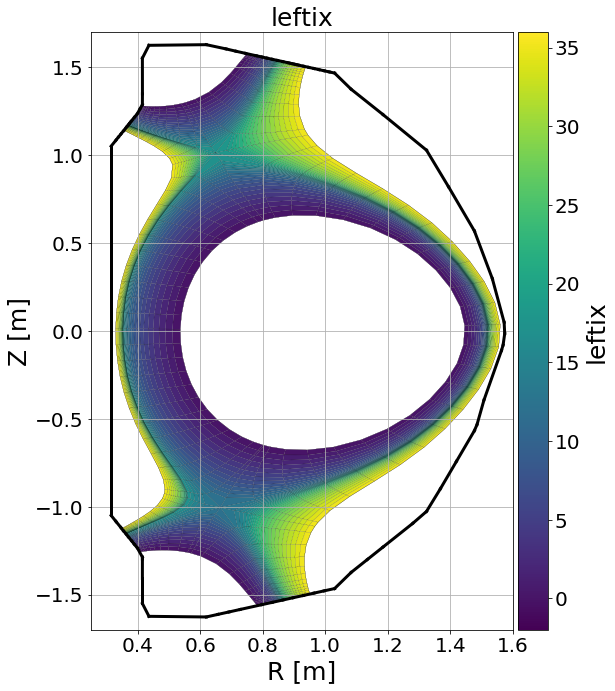

In [5]:
plotvar(b2fgmtry.crx,b2fgmtry.cry,b2fgmtry.leftiy,minColor=-2,maxColor=36,cbScale='linear',
        cbTitle=r'leftix',title='leftix',
        xlims=[0.25,1.6],ylims=[-1.7,1.7],inputLoc=rundir+'input.dat')
# not proportional, change the aspect ratio in functionDoc.py if you want

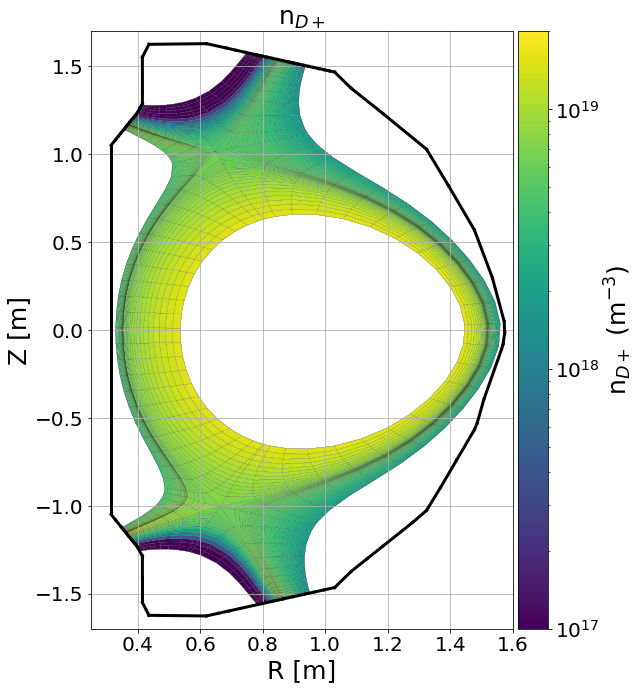

In [6]:
# plotting the D+ density, the third index is the species but this run only has D0 and D+
# the D0 in the B2 quantities is basically nothing because that information is handled by eirene
# so you pretty much always slice along index 1 in the third index in these examples
plotvar(b2fgmtry.crx,b2fgmtry.cry,b2fstate.na[:,:,1],minColor=1e17,maxColor=2e19,cbScale='log',
        cbTitle=r'n$_{D+}$ (m$^{-3}$)',title='n$_{D+}$',
        xlims=[0.25,1.6],ylims=[-1.7,1.7],inputLoc=rundir+'input.dat')

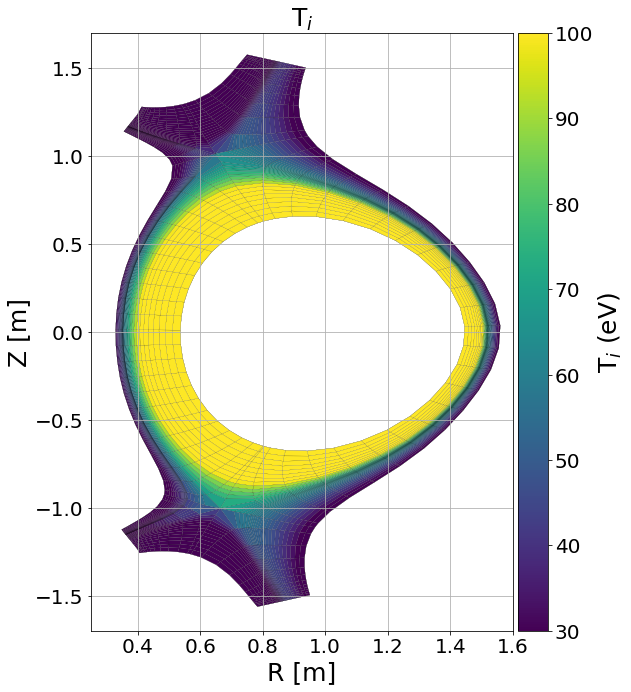

In [7]:
# plotting the ion temperature, there is only one ion temperature in solps so no need to cut by species index
plotvar(b2fgmtry.crx,b2fgmtry.cry,b2fstate.ti/ev,minColor=30,maxColor=100,cbScale='linear',
        cbTitle=r'T$_{i}$ (eV)',title='T$_{i}$',
        xlims=[0.25,1.6],ylims=[-1.7,1.7])

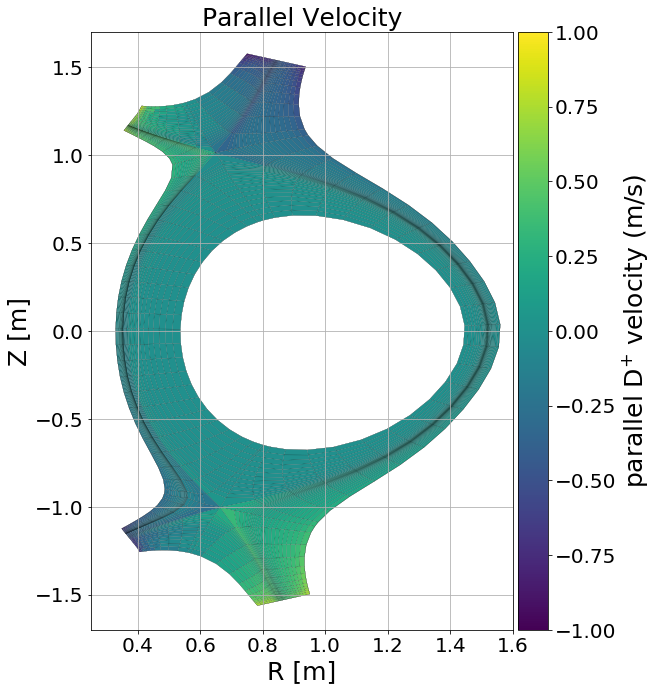

In [8]:
# this is another example of how to plot a variable
# I also calculate the mach number as SOLPS does
# because it is not outputted in the output files
# note that positive is in direction of increasing poloidal index
# which is up for the left side and down for the right side
vth=np.zeros(np.shape(b2fstate.na[:,:,1]))
vel=np.zeros(np.shape(b2fstate.na[:,:,1]))
for iS in range(np.shape(b2fstate.na)[2]):
    if (is_neutral(iS)): continue
    rza=b2fstate.zamin[iS]
    am=b2fstate.am[iS]
    te=b2fstate.te
    ti=b2fstate.ti
    ne=b2fstate.ne
#     ni=b2fplasmf.ni[:,:,1]
    ni=b2fstate.na[:,:,iS]
    na=b2fstate.na[:,:,iS]
    ua=b2fstate.ua[:,:,iS]
    vth=vth+na*(rza*te+ti)/(am*ni*mn)
    vel=vel+ua*rza*na/ne
vth=np.sqrt(vth)
mach = (vel/vth)

plotvar(b2fgmtry.crx,b2fgmtry.cry,mach,minColor=-1,maxColor=1,cbScale='linear',
        cbTitle='parallel D$^{+}$ velocity (m/s)',title='Parallel Velocity',
        xlims=[0.25,1.6],ylims=[-1.7,1.7])

In [9]:
# reads eirene variables (fort.46)  and eirene grid (fort.33,34,35)
ft46 = read_ft46(ft46Loc)
triMesh  = read_triangle_mesh(ft33Loc,ft34Loc,ft35Loc)

done reading ft46 file
read_ft33: assuming ntrfrm = 0.


(7910, 1)


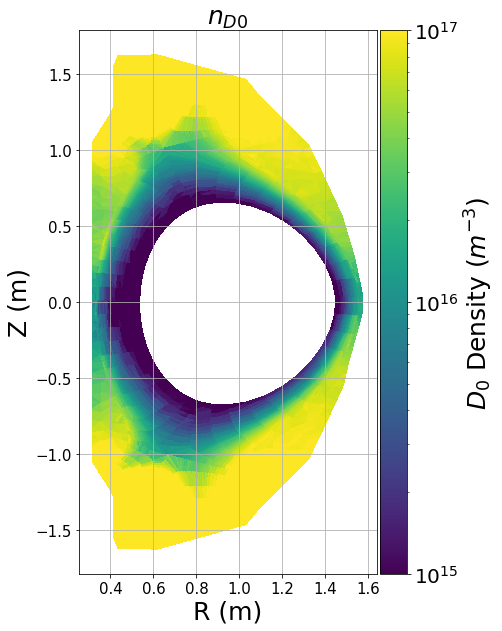

In [10]:
# This is how I do a color plot of the eirene quantities

#plot inputs
maxColor=1e17
minColor=1e15

xMin =0.65
xMax = 0.7
yMin = 1.3
yMax = 1.4

x = triMesh.nodes.T[:,0]
y = triMesh.nodes.T[:,1]

z = ft46.pdena[:,0]#asking for first atom (the only atom in fact for my example)
print(np.shape(ft46.pdenm))#should be shape of nTriangles x number of atoms

triangles = triMesh.cells.T-1
plt.figure(figsize=(6,10))
plt.tripcolor(x,y,triangles,facecolors=z,norm=colorsMPL.LogNorm(vmin=minColor, vmax=maxColor),cmap='viridis')
cb = plt.colorbar(fraction=0.1, pad=0.01)
cb.ax.tick_params(labelsize=20)
cb.set_label(r'$D_0$ Density $(m^{-3})$',fontsize=25)
# plt.xlim([xMin,xMax])
# plt.ylim([yMin,yMax])
plt.grid()
plt.title(r'$n_{D0}$',fontsize=25)
plt.xlabel('R (m)',fontsize=25)
plt.ylabel('Z (m)',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(plotdir+'D2density.png')
plt.show()

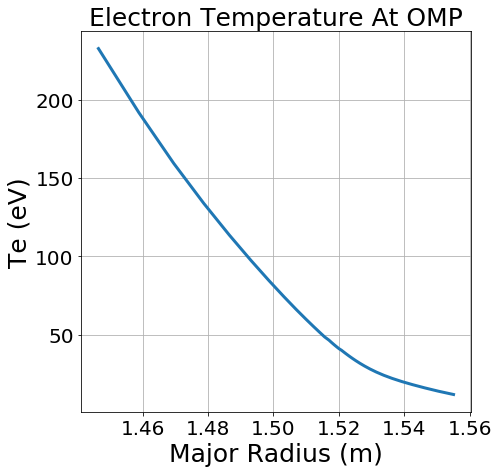

In [11]:
# Here's how to slice at the OMP

# Let's grab the OMP x-index which happens to be 71 for this case
# in SOLPS x-index is the poloidal index, y-index is the radial
# We will also cut off the guard cells by removing the first and last indices of the array
plt.figure(figsize=(7,7))
plt.plot(b2fgmtry.crx[:,:,0][b2fgmtry.leftix==71][1:-1],b2fstate.te[b2fgmtry.leftix==71][1:-1]/1.6e-19,linewidth=3)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Te (eV)',fontsize=25)
plt.xlabel('Major Radius (m)',fontsize=25)
plt.title('Electron Temperature At OMP',fontsize=25)
plt.show()

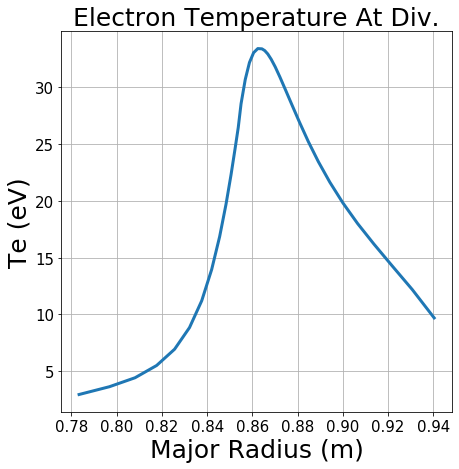

In [12]:
# Here's how to slice at the lower outer divertor

# Let's grab the divertor x-index which happens to be 95 for this case
plt.figure(figsize=(7,7))
plt.plot(b2fgmtry.crx[:,:,0][b2fgmtry.leftix==95][1:-1],b2fstate.te[b2fgmtry.leftix==95][1:-1]/1.6e-19,linewidth=3)
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Te (eV)',fontsize=25)
plt.xlabel('Major Radius (m)',fontsize=25)
plt.title('Electron Temperature At Div.',fontsize=25)
plt.show()